In [10]:

import os

import joblib
import pandas as pd

os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1. / 255)

valid_datagen = ImageDataGenerator(rescale=1. / 255)

In [12]:
valid_datagen = ImageDataGenerator(rescale=1. / 255)
SAVE_DIR = "/Users/Bilal/PycharmProjects/LearningAI/models/assignment_7/task_3"
MODEL_PATH = f"{SAVE_DIR}/food_model_feature_extraction.keras"
HISTORY_PATH = f"{SAVE_DIR}/history_feature_extraction.pkl"

In [13]:
train_dir = "/Users/Bilal/PycharmProjects/LearningAI/Files/assignment_7/task_3/10_food_classes_all_data/train"
test_dir = "/Users/Bilal/PycharmProjects/LearningAI/Files/assignment_7/task_3/10_food_classes_all_data/test"

In [14]:

train_data = train_datagen.flow_from_directory(
    train_dir,
    color_mode="rgb",
    batch_size=32,
    target_size=(224, 224),
    class_mode="categorical"
)

test_data = valid_datagen.flow_from_directory(
    test_dir,
    color_mode="rgb",
    batch_size=32,
    target_size=(224, 224),
    class_mode="categorical"
)

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [15]:
IMAGE_SHAPE = (224, 224)

In [16]:
feature_extractor_layer = hub.KerasLayer(
    efficientnet_url,
    trainable=False,
    name="feature_extraction_layer",
    input_shape=IMAGE_SHAPE + (3,)
)

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(10, activation="softmax", name="output_layer")
])


In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [18]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)


Making a new Model
Epoch 1/5
235/235 [==============================] - ETA: 0s - loss: 0.8086 - accuracy: 0.7831
Epoch 1: val_accuracy improved from -inf to 0.89080, saving model to /Users/Bilal/PycharmProjects/LearningAI/models/assignment_7/task_3/food_model_feature_extraction.keras
235/235 [==============================] - 347s 1s/step - loss: 0.8086 - accuracy: 0.7831 - val_loss: 0.4025 - val_accuracy: 0.8908
Epoch 2/5
235/235 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.8664
Epoch 2: val_accuracy improved from 0.89080 to 0.90440, saving model to /Users/Bilal/PycharmProjects/LearningAI/models/assignment_7/task_3/food_model_feature_extraction.keras
235/235 [==============================] - 310s 1s/step - loss: 0.4450 - accuracy: 0.8664 - val_loss: 0.3336 - val_accuracy: 0.9044
Epoch 3/5
235/235 [==============================] - ETA: 0s - loss: 0.3751 - accuracy: 0.8876
Epoch 3: val_accuracy improved from 0.90440 to 0.91080, saving model to /Users/Bilal/

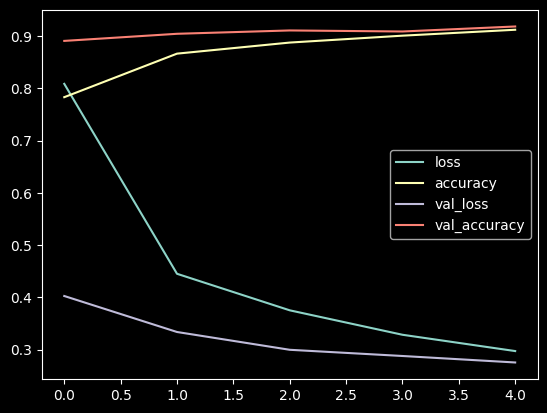

In [19]:

if os.path.exists(MODEL_PATH) and os.path.exists(HISTORY_PATH):
    print("Loading Already Present Model")
    model = tf.keras.models.load_model(MODEL_PATH)
    history = joblib.load(HISTORY_PATH)
    #evaulation
    pd.DataFrame(history).plot()

else:
    print("Making a new Model")

    history = model.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=test_data,
                        validation_steps=len(test_data), callbacks=[checkpoint])
    model.save(MODEL_PATH)
    #savng history
    joblib.dump(history.history, HISTORY_PATH)

    #evaluation
    pd.DataFrame(history.history).plot()